In [13]:
import numpy as np
import pandas as pd

def concat(single, multi, time):
  metrics = list(single.columns[:-5])
  print(metrics)
  del metrics[metrics.index('logdir')]

  single['data_mode'] = 'single-session'
  multi['data_mode'] = 'multi-session'
  time['data_mode'] = 'time-contrastive'

  results = pd.concat(
    [
      single.set_index(metrics),
      multi.set_index(metrics),
      time.set_index(metrics)
    ]
  )
  return metrics, results

root = "/home/stes/ssh/cebra_public/results/figure_4/csvs"

single = pd.read_csv(f"{root}/leave2out-single-bsz7200-long.csv", index_col=0)
multi = pd.read_csv(f"{root}/leave2out-multi-bsz7200-long.csv", index_col=0)
time = pd.read_csv(f"{root}/leave2out-single-bsz7200.csv", index_col=0)
metrics, large_batches = concat(single, multi, time)

#single = pd.read_csv("/home/stes/ssh/cebra_public/leave2out.csv", index_col=0)
#multi = pd.read_csv("/home/stes/ssh/cebra_public/leave2out-multi.csv", index_col=0)
#time = pd.read_csv("/home/stes/ssh/cebra_public/leave2out-timecl.csv", index_col=0)
#metrics, small_batches = concat(single, multi, time)

results = pd.concat([
  large_batches,
  #small_batches  
]).reset_index()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def figure():
  plt.figure(figsize = (3, 2), dpi = 200)


def avg(results, maps):
  results = results.copy()
  for key, remapped in maps.items():
    remapped = key if remapped is None else remapped
    results[remapped + '_raw'] = results[key].apply(lambda v : np.array(eval(v)))
    results[remapped] = results[key].apply(lambda v : np.array(eval(v)).mean())
    
    if key != remapped:
      del results[key]
  return results

maps = {
  'train' : "train_consistency",
  'valid' : "valid_consistency",
  'test' : "test_consistency",
  'valid_accuracy' : None,
  'test_accuracy' : None
}

def agg(values):
  if values.name.endswith("_raw"):
    return np.stack(values, axis = 0).mean(axis = 0)
  return values.mean()

results = avg(results, maps)
metrics = [maps.get(m, m) for m in metrics]
results = results.groupby([ c for c in metrics + ["data_mode"] if c != 'repeat']).agg(agg).reset_index()

print(results.columns)

['batch_size', 'conditional', 'delta', 'device', 'learning_rate', 'logdir', 'loss_distance', 'model', 'num_hidden_units', 'num_output', 'num_steps', 'save_frequency', 'share_model', 'temperature', 'time_offset', 'tqdm', 'train_ratio', 'valid_frequency', 'valid_ratio', 'variant', 'repeat', 'steps']


/tmp/ipykernel_97629/1686836885.py:73: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  results = results.groupby([ c for c in metrics + ["data_mode"] if c != 'repeat']).agg(agg).reset_index()


Index(['batch_size', 'conditional', 'delta', 'device', 'learning_rate',
       'loss_distance', 'model', 'num_hidden_units', 'num_output', 'num_steps',
       'save_frequency', 'share_model', 'temperature', 'time_offset', 'tqdm',
       'train_ratio', 'valid_frequency', 'valid_ratio', 'variant', 'steps',
       'data_mode', 'repeat', 'valid_accuracy', 'test_accuracy',
       'train_consistency_raw', 'train_consistency', 'valid_consistency_raw',
       'valid_consistency', 'test_consistency_raw', 'test_consistency',
       'valid_accuracy_raw', 'test_accuracy_raw'],
      dtype='object')


In [25]:
import json
import pandas as pd

def read_data(fname):
  with open(fname, 'r') as fh:
    single = filter(len, fh.read().split("@@"))
  
  data = []
  errors = []
  for i, line in enumerate(single):
    try:
      line = json.loads(line)
    except json.JSONDecodeError as e:
      try:
        first, second = line.split("}{")
        first = json.loads(first + "}")
        second = json.loads("{" + second)
        assert first == second
        line = first
      except:
        errors.append(i)
        continue
    data.append({
      key : (tuple(value) if isinstance(value, list) else value)
      for key, value in line.items()
    })
  print(len(errors))  
  return pd.DataFrame(data), errors

singlesession, _ = read_data('/home/stes/ssh/cebra_public/results/figure_4/allen-10seed/singlesession.json')

1


In [27]:
! head /home/stes/ssh/cebra_public/results/figure_4/allen-10seed/singlesession.json

{"data": "allen-movie1-ca-single-session-leave2out-1-repeat-4-train", "variant": "single-session", "logdir": "/logs", "loss_distance": "cosine", "temperature": 1.0, "time_offset": 10, "delta": 0.1, "conditional": "time_delta", "num_steps": 5000, "learning_rate": 0.003, "model": "offset10-model", "models": [], "batch_size": 7200, "num_hidden_units": 128, "num_output": 128, "device": "cuda", "tqdm": false, "save_frequency": 50, "valid_frequency": 100, "train_ratio": 0.8, "valid_ratio": 0.1, "share_model": false, "save_emissions": false, "splits": [], "valid_acc": [56.56565656565656, 56.56565656565656, 56.22895622895623, 56.00448933782267, 55.892255892255896], "test_acc": [46.12794612794613, 46.352413019079684, 46.68911335578002, 47.02581369248036, 47.25028058361392], "knn": [1, 4, 9, 16, 25], "filename": "results_0001950.jl", "session_idx": 0}
{"data": "allen-movie1-ca-single-session-leave2out-1-repeat-4-train", "variant": "single-session", "logdir": "/logs", "loss_distance": "cosine", "

In [14]:
filtered_results = results[
  (results.batch_size == 7200) & 
  (results.learning_rate == 0.003) & 
  (results.num_output == 128) &
  (results.num_hidden_units == 128)
  #(results.steps == 1000)
].set_index("data_mode")

filtered_results = filtered_results[filtered_results["valid_accuracy"] > 60]
filtered_results = filtered_results.sort_values("valid_accuracy").groupby("data_mode").head(1)#["valid_accuracy"]

filtered_results["steps"]

data_mode
single-session      200
multi-session       800
time-contrastive    250
Name: steps, dtype: int64

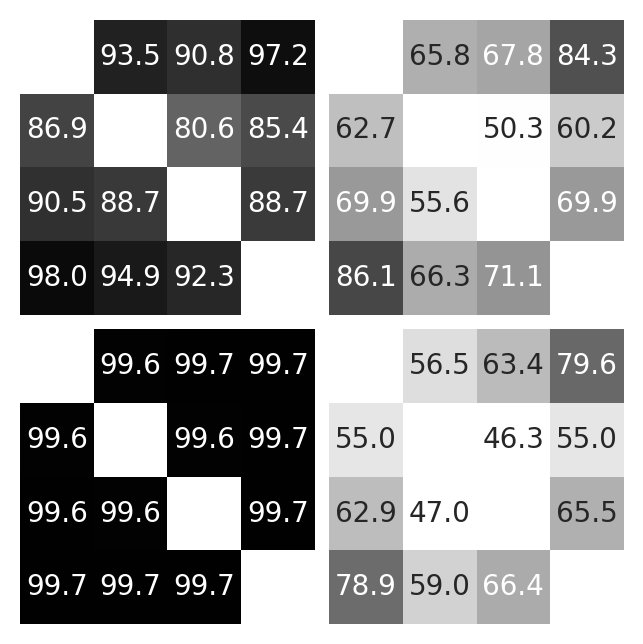

In [15]:
def show_sweep(df):
  for c in df.columns:
    try:
      values = df[c].unique()
    except TypeError:
      continue
    #if len(values) != len(df):
    if len(values) > 1:
      print(c, values)

_, axes = plt.subplots(2,2,figsize=(4, 4), dpi = 200)

for ax_row, data_mode in zip(axes, ["single-session", "multi-session"]):
  
  for ax, split in zip(ax_row, ["train", "test"]):
  
    values = filtered_results[f"{split}_consistency_raw"].loc[data_mode]

    cfm = np.zeros((4,4))
    cfm[:] = float("nan")
    cfm[~np.eye(4).astype(bool)] = values
    sns.heatmap(
      cfm * 100, 
      cmap = 'gray_r', 
      vmin = 50, 
      vmax = 100, 
      annot = True, 
      fmt = '.1f', 
      square = True, 
      cbar = False,
      ax = ax
    )
    ax.axis("off")
    
    #ax.set_title(f"{data_mode} {split}")
plt.subplots_adjust(wspace=-0.005, hspace=0.05)
plt.show()

data_mode
multi-session     2500
single-session    2500
Name: steps, dtype: int64

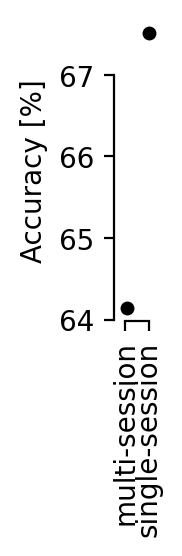

In [30]:
metric = "test_accuracy"

filtered_results = results[
  (results.batch_size == 7200) & 
  (results.learning_rate == 0.003) & 
  (results.num_output == 128) &
  (results.num_hidden_units == 128) &
  (results.steps == 2500)
].sort_values("valid_accuracy").groupby("data_mode").tail(1).set_index("data_mode") #.drop("time-contrastive")

#baseline = results[
  #(results.batch_size == 512) & 
  #(results.learning_rate == 0.0003) & 
  #(results.steps == 50)
#].sort_values("valid_accuracy").head(1).set_index("data_mode")

#baseline = baseline.rename({'multi-session' : 'baseline'})
display(filtered_results.steps)

#filtered_results = pd.concat([filtered_results]).drop("time-contrastive").sort_values("valid_accuracy", ascending = True)

plt.figure(figsize = (.3,2), dpi = 200)
sns.stripplot(
  data = filtered_results.reset_index(),
  y = metric,
  x = "data_mode",
  dodge = False,
  color = "black"
)
sns.despine(trim = True)
plt.ylabel("Accuracy [%]")
plt.xlabel("")
#plt.gca().set_xticklabels(["single", "multi"])
plt.xticks(rotation=90)
plt.show()

In [7]:
def _select(values):
  index, values = values[0], values[1:]
  return values[index]

def hyperparameter_pivot(data, select_with, metric, index = [], columns = [], select_func = np.argmin):
  
  idx = data.pivot_table(
    select_with,
    index = index,
    columns = columns,
    aggfunc = lambda v : (select_func(v),)
  )

  agg = data.pivot_table(
    metric,
    index = index,
    columns = columns,
    aggfunc = tuple
  )
  
  if len(agg.columns) == 1:
    idx.columns = [metric]
    agg.columns = [metric]
  
  return (idx + agg).applymap(_select)


from IPython.display import display, HTML

KEYS = 'train_consistency','valid_consistency','test_consistency','valid_accuracy','test_accuracy'

def show_results(
    select_by = "valid_accuracy",
    func = np.argmax,
    keys = KEYS
  ):

  frames = (hyperparameter_pivot(
      results,
      select_by,
      key,
      index = ['data_mode'],
      columns = ['batch_size'],
      select_func=func,
    ) * (100 if "consistency" in key else 1)
    for key in keys)

  display(HTML("<style>.container { width:100% !important; }</style>"))

  titles = [
    "Consistency (R², train)",
    "Consistency (R², valid)",
    "Consistency (R², test)",
    "Accuracy (valid)",
    "Accuracy (test)",
  ]

  #summary = pd.concat(frames, axis = 1)
  #summary.columns = titles
  #return HTML(summary.style.format(precision = 2)._repr_html_())

  return HTML(("\xa0" * 3).join(
    frame.style.set_table_attributes("style='display:inline'").set_caption(title).format(precision = 2)._repr_html_()
    for frame, title in zip(frames, titles))
  )

select_metrics = 'train_consistency','valid_consistency','valid_accuracy'
for key in select_metrics:
  display(show_results(key))
  print('selected by best', key)

,train_consistency
data_mode,
multi-session,99.88
single-session,98.56
time-contrastive,95.81
,valid_consistency
data_mode,
multi-session,53.69
single-session,56.29
time-contrastive,58.34
,test_consistency


selected by best train_consistency


,train_consistency
data_mode,
multi-session,93.14
single-session,82.59
time-contrastive,82.34
,valid_consistency
data_mode,
multi-session,72.34
single-session,70.75
time-contrastive,70.52
,test_consistency


selected by best valid_consistency


,train_consistency
data_mode,
multi-session,99.88
single-session,98.54
time-contrastive,95.81
,valid_consistency
data_mode,
multi-session,53.75
single-session,56.31
time-contrastive,58.34
,test_consistency


selected by best valid_accuracy


In [8]:
hyperparams = [
 'batch_size',
 'conditional',
 'learning_rate',
 'num_hidden_units',
 'num_output',
 'save_frequency',
  "steps",
 'share_model',
 'temperature',
 'time_offset', 'data_mode']

In [9]:
d1 = list(results.sort_values("valid_consistency").groupby(['data_mode']).tail(1)[hyperparams].sort_values("data_mode").T.to_dict().values())
d2 = list(results.sort_values("valid_accuracy").groupby(['data_mode']).tail(1)[hyperparams].sort_values("data_mode").T.to_dict().values())

def merge(d1, d2):
  assert d1.keys() == d2.keys()
  for k, v in d1.items():
    d1[k] = [d1[k], d2[k]]
  
for a,b in zip(d1, d2):
  merge(a,b)
  print(a["data_mode"])
  del a['data_mode']
  print(a)
  print()

['multi-session', 'multi-session']
{'batch_size': [7200, 7200], 'conditional': ['time_delta', 'time_delta'], 'learning_rate': [0.003, 0.003], 'num_hidden_units': [128, 128], 'num_output': [128, 128], 'save_frequency': [50, 50], 'steps': [50, 4900], 'share_model': [False, False], 'temperature': [1, 1], 'time_offset': [10, 10]}

['single-session', 'single-session']
{'batch_size': [7200, 7200], 'conditional': ['time_delta', 'time_delta'], 'learning_rate': [0.003, 0.003], 'num_hidden_units': [128, 128], 'num_output': [128, 128], 'save_frequency': [50, 50], 'steps': [50, 4850], 'share_model': [False, False], 'temperature': [1, 1], 'time_offset': [10, 10]}

['time-contrastive', 'time-contrastive']
{'batch_size': [7200, 7200], 'conditional': ['time_delta', 'time_delta'], 'learning_rate': [0.003, 0.003], 'num_hidden_units': [128, 128], 'num_output': [128, 128], 'save_frequency': [50, 50], 'steps': [50, 1000], 'share_model': [False, False], 'temperature': [1, 1], 'time_offset': [10, 10]}



<AxesSubplot:xlabel='valid_consistency', ylabel='valid_accuracy'>

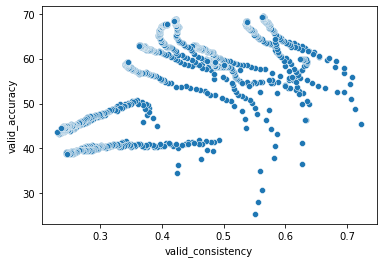

In [10]:
results_ = results.pivot_table(
  key,
  index = ['data_mode', 'batch_size'],
  columns = ['steps'],
  aggfunc = "max"
).stack()

sns.scatterplot(data = results[results.batch_size == 7200], x = 'valid_consistency', y = 'valid_accuracy')

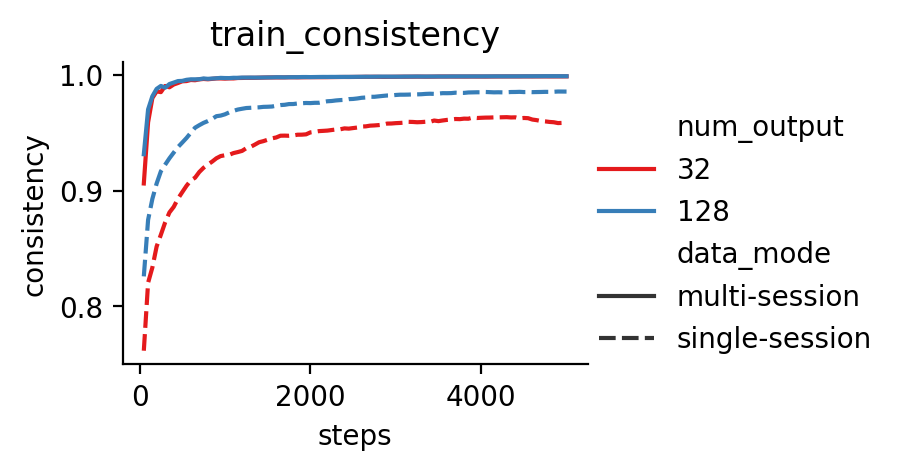

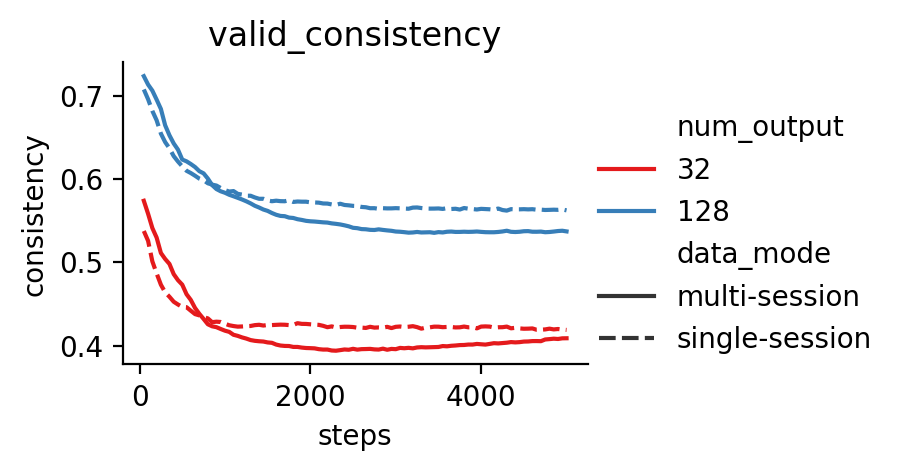

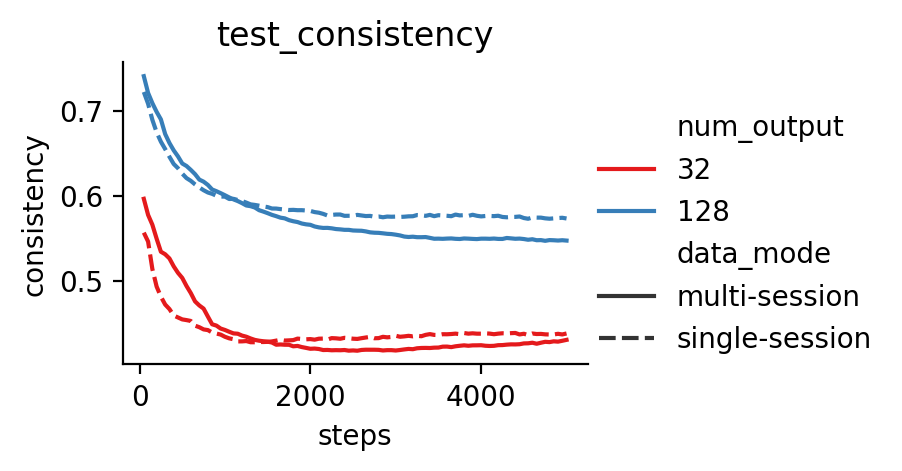

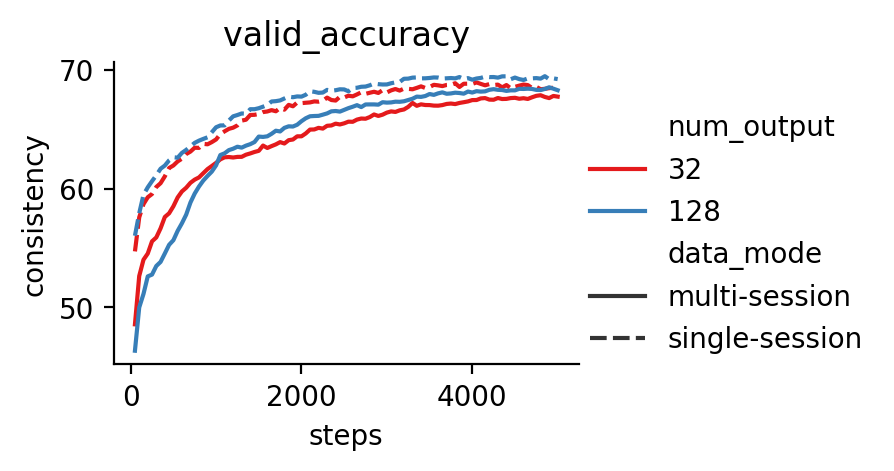

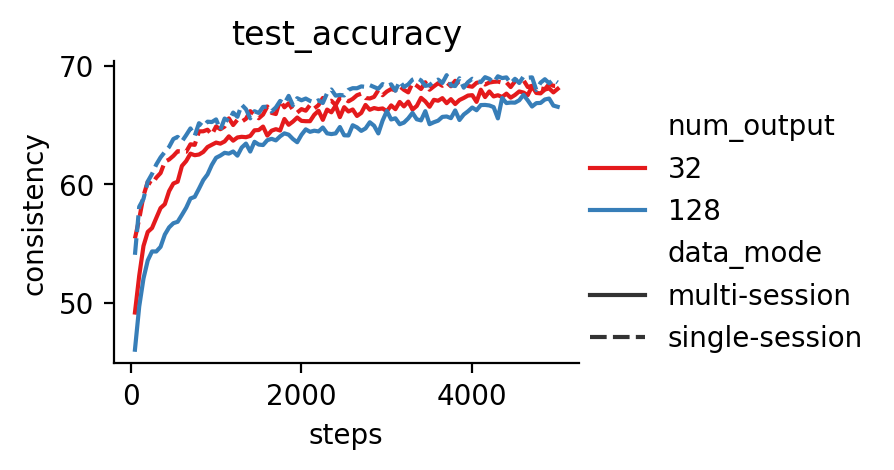

In [11]:
def plot(results, key):
  
  results = results.copy()
  results = results[results.data_mode != "time-contrastive"]
  
  figure()
  
  index = 'num_output'

  results = results.pivot_table(
    key,
    index = ['data_mode', index],
    columns = ['steps'],
    aggfunc = "max"
  ).stack()

  results.name = 'consistency'
  results = results.reset_index()

  sns.lineplot(
    data = results,
    x = 'steps',
    y = 'consistency',
    hue = index,
    style = 'data_mode',
    palette = 'Set1'
  )
  plt.legend(loc=(1,0),frameon = False)
  
  sns.despine(trim = False)
  plt.title(key)
  plt.show()
  
plot(results, "train_consistency")
plot(results, "valid_consistency")
plot(results, "test_consistency")

plot(results, "valid_accuracy")
plot(results, "test_accuracy")